In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,7,5)
timeStart = datetime.datetime(2011,7,5,3,0)
timeEnd = datetime.datetime(2011,7,5,7,0)
sapsTime = datetime.datetime(2011,7,5,5,0)
tecScale = [ 0, 10 ]
trghLatRange = [ 50, 75 ]
tecMlon = -70 + 360
nrstMlonCutoff = 2

In [3]:
# read TEC data from the feather file
tecDF = feather.read_dataframe('../data/tec-mf-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
tecDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date,MLT
0,20110705,300,11.0,0.0,5.4,1.0,2.0,2011-07-05 03:00:00,22.205744
1,20110705,300,11.0,2.0,10.2,1.0,2.0,2011-07-05 03:00:00,22.339078
2,20110705,300,11.0,4.0,8.9,1.0,2.0,2011-07-05 03:00:00,22.472411
3,20110705,300,11.0,6.0,7.5,1.0,2.0,2011-07-05 03:00:00,22.605744
4,20110705,300,11.0,8.0,7.4,1.0,2.0,2011-07-05 03:00:00,22.739078


In [4]:
# Get the min loc of trough at diff MLONs
trghLocsDF = tecDF[ (tecDF["med_tec"] <= 20.) &\
                  (tecDF["Mlat"] >= trghLatRange[0]) &\
                  (tecDF["Mlat"] <= trghLatRange[1]) ]
trghLocsDF["time"] = [ date2num(x) for x in trghLocsDF["date"] ]
trghMinDF = trghLocsDF[ ["time", "Mlon", "med_tec"]\
                 ].groupby( [ "time", "Mlon" ]\
                ).min().reset_index()
trghMinDF["Mlon2"] = [x-360 if x>180 else x for x in trghMinDF["Mlon"] ]
trghMinDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,time,Mlon,med_tec,Mlon2
0,734323.125,0.0,4.6,0.0
1,734323.125,2.0,4.2,2.0
2,734323.125,4.0,4.2,4.0
3,734323.125,6.0,4.0,6.0
4,734323.125,8.0,4.9,8.0


In [5]:
trghMlatDF = pandas.merge( trghLocsDF[ ["time", "Mlon", "Mlat",\
                            "date", "med_tec"] ],\
                          trghMinDF,\
                          on=["time", "Mlon", "med_tec"] )
# drop duplicates
trghMlatDF = trghMlatDF.drop_duplicates(\
                    subset=["time", "Mlon",  "Mlon2"], keep="first")
trghMlatDF.head()

,time,Mlon,Mlat,date,med_tec,Mlon2
0,734323.125,130.0,50.0,2011-07-05 03:00:00,9.6,130.0
3,734323.125,142.0,50.0,2011-07-05 03:00:00,7.9,142.0
6,734323.125,166.0,50.0,2011-07-05 03:00:00,9.8,166.0
7,734323.125,180.0,50.0,2011-07-05 03:00:00,12.0,180.0
8,734323.125,198.0,50.0,2011-07-05 03:00:00,5.8,-162.0


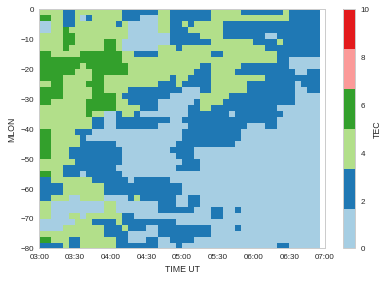

In [6]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = trghMinDF[ ["time", "Mlon2",\
                        "med_tec"] ].pivot( "time", "Mlon2" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
tecVals = numpy.ma.masked_where(\
                numpy.isnan(plotDF["med_tec"].values),\
                plotDF["med_tec"].values)
rtiPlot = ax.pcolormesh(timeCntr.T, mlonCntr.T , tecVals,\
                        cmap=seaMap, vmin=tecScale[0],vmax=tecScale[1])

ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [ -80, 0 ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLON")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_xticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("TEC")

fig.savefig("../plots/tec-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

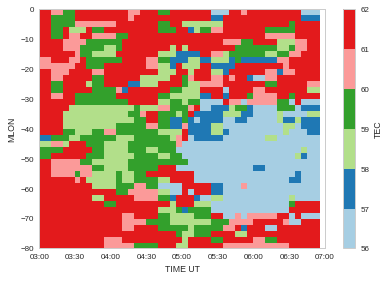

In [7]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = trghMlatDF[ ["time", "Mlon2",\
                        "Mlat"] \
                   ].pivot( "time", "Mlon2" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
mlatVals = numpy.ma.masked_where(numpy.isnan(\
                plotDF["Mlat"].values), plotDF["Mlat"].values)
rtiPlot = ax.pcolormesh(timeCntr.T, mlonCntr.T , mlatVals,\
                        cmap=seaMap, vmin=56., vmax=62.)

ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [ -80, 0 ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLON")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_xticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("TEC")

fig.savefig("../plots/tec-lats-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


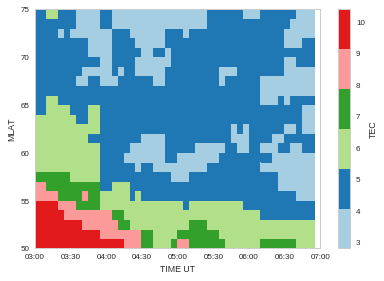

In [8]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
# setup the figure
fig = plt.figure()
ax = fig.add_subplot(111)
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
    
selDF = tecDF[ ((tecDF["date"] >= timeStart) &\
                       (tecDF["date"] <= timeEnd) &\
                    (tecDF["Mlat"] <= trghLatRange[1]) &\
                       (tecDF["Mlat"] >= trghLatRange[0]) )]
selDF["time"] = [ date2num(x) for x in selDF["date"] ]
selDF = selDF[ ["Mlat", "time", "med_tec"]\
             ].groupby( ["Mlat", "time"] ).median().reset_index()

plotmedFiltTECDF = selDF[ ["Mlat", "time",\
                        "med_tec"] ].pivot( "Mlat", "time" )
mlatVals = plotmedFiltTECDF.index.values
timeVals = plotmedFiltTECDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
med_tecVals = numpy.ma.masked_where(numpy.isnan(plotmedFiltTECDF["med_tec"].values),plotmedFiltTECDF["med_tec"].values)
trghPlot = ax.pcolormesh(timeCntr, mlatCntr,med_tecVals.T,cmap=seaMap)
ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(trghPlot, orientation='vertical')
cbar.set_label("TEC")

fig.savefig("../plots/tec-long-cut-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')